In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.notebook import tqdm
import warnings
import time

np.set_printoptions(linewidth=200, suppress=True, precision=3)

# Функции и классы

In [2]:
def plot_class_distribution(classes, title):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    sns.countplot(x = classes)
    plt.title(f'Распределение классов {title}')
    plt.xlabel('Цифры')
    plt.show()

    # Reset the warning filter to its default state
    warnings.filterwarnings("default")

def reduce_dataset(X, y, reduce_to):

    idx = []

    for i in range(10):
        # Найти индексы примеров, соответствующих данному классу
        idx_i = np.where(y == i)[0]
        # Случайным образом выбрать подмножество индексов
        idx_i = np.random.choice(idx_i, size=reduce_to, replace=False)
        idx.extend(idx_i)

    np.random.shuffle(idx)

    return (X[idx], y[idx])

# Импортируем библиотеку numpy для работы с массивами
import numpy as np

# Определяем функцию, которая принимает датасет mnist в виде двух массивов: images и labels
# А также желаемый размер подмножества: subset_size
def reduce_mnist(images, labels, subset_size):
  # Проверяем, что subset_size не превышает размер датасета
    if subset_size > len(images):
        print("Ошибка: subset_size больше, чем размер датасета")
        return None, None
  # Создаем массив индексов от 0 до размера датасета
    indices = np.arange(len(images))
    # Перемешиваем массив индексов случайным образом
    np.random.shuffle(indices)
    # Выбираем subset_size первых индексов из перемешанного массива
    subset_indices = indices[:subset_size]
    # Используем subset_indices для выбора соответствующих изображений и меток из датасета
    subset_images = images[subset_indices]
    subset_labels = labels[subset_indices]
  # Возвращаем подмножество изображений и меток
    return subset_images, subset_labels


def cross_entropy_loss(y_true, y_pred):
    
    y_pred = y_pred + 1e-9
    # Вычисляем ошибку по формуле: L = - 1/N * sum y_true* log(y_pred)
    loss = - np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    # Вычисляем градиент по формуле: dL/dy_pred = - y_true/ y_pred
    dloss = - y_true / y_pred

    return loss, dloss


In [3]:
class Layer:
    def __init__(self):
        self.cache = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, np.sqrt(2/input_size), (input_size, output_size))
        self.bias = np.random.normal(0, 1, (output_size))
        self.gW = 0
        self.gB = 0

    def forward(self, X):
        out = np.dot(X, self.weights) + self.bias
        # Cохраняем для бэкпропа
        self.cache = X
        return out

    def backward(self, dout, learning_rate):
        X = self.cache

        # Cчитаем градиенты
        dX = np.dot(dout, self.weights.T).reshape(X.shape)
        self.gW = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.gB = np.sum(dout, axis=0)
        
        # Обновляем веса
        self.weights -= learning_rate * self.gW
        self.bias -= learning_rate * self.gB

        return dX

class Сonvolution(Layer):
    def __init__(self, C_in, C_out, kernel_size, stride=1, padding=0):

        self.C_in = C_in # количество входных каналов
        self.C_out = C_out # количество выходных каналов
        self.K = kernel_size # размер ядра свертки
        self.S = stride # шаг свертки
        self.P = padding # дополнение нулями

        # self.weights = np.random.randn(C_out, C_in, kernel_size, kernel_size)
        self.weights = np.random.normal(0.0,np.sqrt(2/C_in),(C_out,C_in,kernel_size,kernel_size))
        self.bias = np.random.randn(C_out)

        self.dW = None
        self.dB = None

        # Сохраняем вход и выход сверточного слоя для бэкпропа
        self.X = None
        self.Y = None

    def forward(self, X):
        # X - тензор размером (N, C, H, W), где N - кол-во объектов, C - кол-во каналов, H - высота, W - ширина
        # Возвращает тензор размером (N, F, H', W'), где F - кол-во выходных каналов, H' и W' - высота и ширина после свертки
        # Кешируем
        self.X = X

        # Вычисляем размеры выхода
        N, C, H, W = X.shape
        F, C, K, K = self.weights.shape
        H_out = (H + 2 * self.P - K) // self.S + 1
        W_out = (W + 2 * self.P - K) // self.S + 1

        # Создаем выходной тензор
        out = np.zeros((N, F, H_out, W_out))

        # Добавляем дополнение нулями к входному тензору, если необходимо
        if self.P > 0:
            x_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
            x_padded[:, :, self.P:-self.P, self.P:-self.P] = X
        else:
            x_padded = X

        # Проходимся по всему тензору
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна свертки на входном тензоре
                        i_start = i * self.S
                        i_end = i_start + K
                        j_start = j * self.S
                        j_end = j_start + K
                        # Вырезаем окно свертки из входного тензора
                        x_slice = x_padded[n, :, i_start:i_end, j_start:j_end]
                        # Вычисляем элемент выходного тензора по формуле (X_slice * K + b)
                        out[n, f, i, j] = np.sum(x_slice * self.weights[f]) + self.bias[f]

        # Кешируем
        self.Y = out

        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору размером (N, F, H', W')
        # Возвращает градиент по входному тензору размером (N, C, H, W)

        # Достаем размеры входного и выходного тензоров
        N, C, H, W = self.X.shape
        F, C, K, K = self.weights.shape
        N, F, H_out, W_out = dout.shape

        # Создаем градиент по входному тензору
        dX = np.zeros((N, C, H, W))

        # Дополнение 0,  если необходимо
        if self.P > 0:
            x_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
            x_padded[:, :, self.P:-self.P, self.P:-self.P] = self.X
            dx_padded = np.zeros((N, C, H + 2 * self.P, W + 2 * self.P))
        else:
            x_padded = self.X
            dx_padded = dX

        # Создаем градиент по весам и смещениям
        self.dW = np.zeros((F, C, K, K))
        self.dB = np.zeros((F))

        # Проходимся по всему тензору
        for n in range(N):
            for f in range(F):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна свертки на входном тензоре
                        i_start = i * self.S
                        i_end = i_start + K
                        j_start = j * self.S
                        j_end = j_start + K
                        # Вырезаем окно свертки из входного тензора и градиента по входному тензору
                        x_slice = x_padded[n, :, i_start:i_end, j_start:j_end]
                        dx_slice = dx_padded[n, :, i_start:i_end, j_start:j_end]
                        # Обновляем градиент по весам и смещениям
                        self.dW[f] += x_slice * dout[n, f, i, j]
                        self.dB[f] += dout[n, f, i, j]
                        # Обновляем градиент по входному тензору
                        dx_slice += np.rot90(self.weights[f], 2) * dout[n, f, i, j]

        # Удаляем дополнение 0, если необходимо
        if self.P > 0:
            dX = dx_padded[:, :, self.P:-self.P, self.P:-self.P]
        
        # Обновляем веса и смещения
        self.weights -= learning_rate * self.dW
        self.bias -= learning_rate * self.dB
        
        return dX

class MaxPooling(Layer):
    def __init__(self, pool_size, stride):
        self.p_s = pool_size # размер окна пулинга
        self.s = stride # шаг пулинга

        self.X = None
        self.mask = None

    def forward(self, X):
        # X - тензор размером (N, C, H, W), где N - кол-во объектов, C - кол-во каналов, H - высота, W - ширина
        # Возвращает тензор размером (N, F, H', W'), где F - кол-во выходных каналов, H' и W' - высота и ширина после пулинга

        # Кешируем
        self.X = X

        # Вычисляем размеры выходного тензора
        N, C, H, W = X.shape
        K = self.p_s
        S = self.s
        H_out = (H - K) // S + 1
        W_out = (W - K) // S + 1

        # Создаем выходной тензор и маску пулинга
        out = np.zeros((N, C, H_out, W_out))
        self.mask = np.zeros((N, C, H, W))

        # Проходимся по тензору
        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна пулинга на входном тензоре
                        i_start = i * S
                        i_end = i_start + K
                        j_start = j * S
                        j_end = j_start + K
                        # Вырезаем окно пулинга из входного тензора
                        x_slice = X[n, c, i_start:i_end, j_start:j_end]
                        # Вычисляем элемент выходного тензора как максимум окна пулинга
                        out[n, c, i, j] = np.max(x_slice)
                        # Записываем маску пулинга, помечая единицей позицию максимального элемента в окне пулинга
                        i_max, j_max = np.unravel_index(np.argmax(x_slice), x_slice.shape)
                        self.mask[n, c, i_start + i_max, j_start + j_max] = 1

        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору размером (N, C, H', W')
        # Возвращает градиент по входному тензору размером (N, C, H, W)

        # Вычисляем размеры входного и выходного тензоров
        N, C, H, W = self.X.shape
        N, C, H_out, W_out = dout.shape
        K = self.p_s
        S = self.s

        # Создаем градиент по входному тензору
        dX = np.zeros((N, C, H, W))

        # Проходимcя по тензору
        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        # Вычисляем координаты окна пулинга на входном тензоре
                        i_start = i * S
                        i_end = i_start + K
                        j_start = j * S
                        j_end = j_start + K
                        # Вырезаем окно пулинга из градиента по входному тензору
                        dx_slice = dX[n, c, i_start:i_end, j_start:j_end]
                        # Обновляем градиент по входному тензору, умножая градиент по выходному тензору на маску пулинга
                        dx_slice += dout[n, c, i, j] * self.mask[n, c, i_start:i_end, j_start:j_end]
        return dX

class Softmax(Layer):
    def __init__(self):
        self.Y = None

    def forward(self, X):
        # Нормализуем x, вычитая среднее значение по строкам
        # X = X - np.mean(X, axis=1, keepdims=True)
        # Вычисляем экспоненты входных значений
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.Y = exps / np.sum(exps, axis=1, keepdims=True)
        return self.Y

    def backward(self, dout, learning_rate):
        # Вычисляем градиент softmax по входу
        # Используем формулу: dL/dx_i = y_i * (dL/dy_i - sum_j dL/dy_j * y_j)
        # Где L - функция потерь, x - вход, y - выход softmax, i и j - индексы элементов
        # dout - градиент по выходу softmax
        dX = self.Y * (dout - np.sum(dout * self.Y, axis=1, keepdims=True))
        # Возвращаем градиент по входу
        return dX
        
class Reshape(Layer):
    def __init__(self, new_shape):
        # Сохраняем новую форму тензора
        self.new_shape = new_shape
        # Сохраняем старую форму тензора для обратного распространения
        self.old_shape = None

    def forward(self, x):
        # x - входной тензор любой формы
        # Возвращает выходной тензор с новой формой
        self.old_shape = x.shape
        out = x.reshape(self.new_shape)
        return out

    def backward(self, dout, learning_rate):
        # dout - градиент по выходному тензору с новой формой
        # Возвращает градиент по входному тензору со старой формой
        dx = dout.reshape(self.old_shape)
        return dx

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.cache = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, X):
        # X - выход предыдущего слоя, тензор любой формы
        # Возвращает результат применения функции активации к X
        self.cache = X
        return self.activation(self.cache)

    def backward(self, dout, learning_rate):
        # dout - градиент по выходу слоя, тензор той же формы, что и X
        # Возвращает градиент по входу слоя
        X = self.cache
        return np.multiply(dout, self.activation_prime(X))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class NerualNetworkBase:
    def __init__(self, architecture, loss_fn):
        self.arch = architecture
        self.loss_fn = loss_fn
        self.history_loss = []
        self.total_time = 0

    def predict(self, input):
        output = input
        # Проходимся по всем слоям вызывая метод forward с выходом предыдущего.
        for layer in self.arch:
            output = layer.forward(output)
        return output
    
    def train(self, X_train, y_train, batch_size, learning_rate, epochs, print_batch_loss = False, print_epoch_loss = False):
        
        for e in range(epochs):
            
            error = 0
            error_buffer = []
            
            # Перемешиваем
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            total_batches = len(X_train) // batch_size
            start = time.time()

            for i in range(0, len(X_train), batch_size):
                
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # Forward
                y_pred = self.predict(x_batch)
                # Loss
                error, grad = self.loss_fn(y_batch, y_pred)
                # Сохраняем ошибку
                error_buffer.append(error)
                
                if print_batch_loss:
                    print(f'Batch {int(i/batch_size) + 1} of {total_batches}, error: {format(error, ".8f")}')
                
                # Backward
                for layer in reversed(self.arch):
                    grad = layer.backward(grad, learning_rate)
            
            end = time.time()
            epoch_time = end - start
            self.total_time += epoch_time
            
            mean_loss = np.mean(error_buffer)
            
            if print_epoch_loss:
                print(f'### Epoch: {e + 1}, time: {round(epoch_time, 2)}s, mean loss: {format(mean_loss, ".8f")}')
            
            self.history_loss.append(mean_loss)
    def print_total_time(self):
        print('Total training time: ', round(self.total_time, 2), 's')

    def show_loss(self, size = (8,6)):
        plt.figure(figsize=size)
        plt.plot(self.history_loss)
        plt.title('Mean loss per epoch')
        plt.show()
    
    def get_loss(self):
        return self.history_loss
        

# Предобработка данных

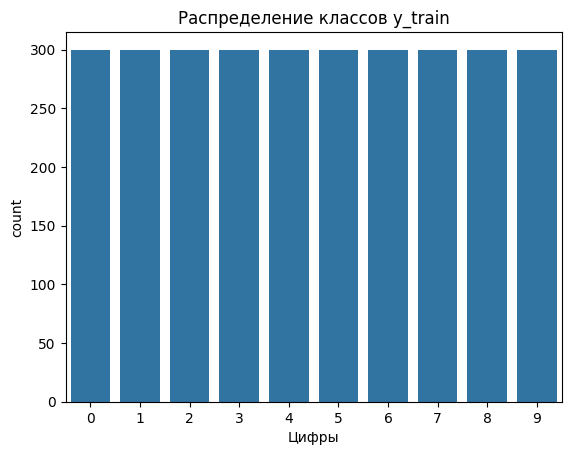

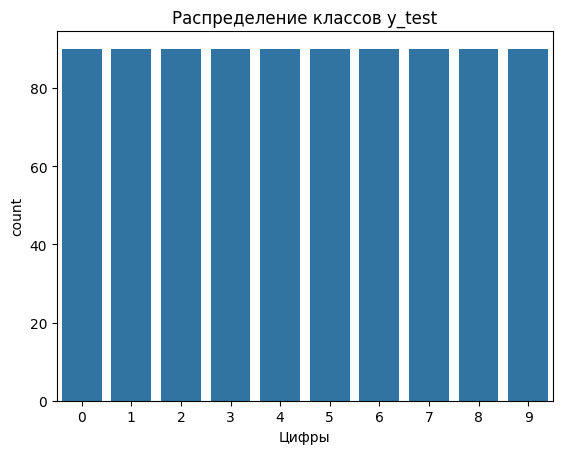

X train shape (3000, 784)
y train shape (3000, 10)
X test shape (900, 784)
y test shape (900, 10)


In [20]:
np.random.seed(0)

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X = np.concatenate((x_train, x_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)

# Для теста
X_train, y_train = reduce_dataset(X_train, y_train, 300)
X_test, y_test = reduce_dataset(X_test, y_test, 90)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=1)

plot_class_distribution(y_train, 'y_train')
plot_class_distribution(y_test, 'y_test')


# Преодбработка
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0], -1)

print("X train shape", X_train.shape)
print("y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)

# Простой 3-х слойный персептрон
### Архитектура
#### Input ► Dense-120 ► Softmax ► Output 
* Lr = 0.00001
* batch_size = 64
* epochs = 20


### Epoch: 1, time: 0.03s, mean loss: 2.39319706
### Epoch: 2, time: 0.03s, mean loss: 1.94089989
### Epoch: 3, time: 0.05s, mean loss: 1.70360140
### Epoch: 4, time: 0.03s, mean loss: 1.51428366
### Epoch: 5, time: 0.03s, mean loss: 1.35873418
### Epoch: 6, time: 0.03s, mean loss: 1.23149851
### Epoch: 7, time: 0.05s, mean loss: 1.12573964
### Epoch: 8, time: 0.03s, mean loss: 1.03783252
### Epoch: 9, time: 0.03s, mean loss: 0.96434122
### Epoch: 10, time: 0.03s, mean loss: 0.90152504
### Epoch: 11, time: 0.03s, mean loss: 0.84806914
### Epoch: 12, time: 0.03s, mean loss: 0.80185363
### Epoch: 13, time: 0.03s, mean loss: 0.76210514
### Epoch: 14, time: 0.04s, mean loss: 0.72723395
### Epoch: 15, time: 0.02s, mean loss: 0.69606575
### Epoch: 16, time: 0.03s, mean loss: 0.66829677
### Epoch: 17, time: 0.03s, mean loss: 0.64422707
### Epoch: 18, time: 0.03s, mean loss: 0.62244986
### Epoch: 19, time: 0.03s, mean loss: 0.60280469
### Epoch: 20, time: 0.03s, mean loss: 0.58473360
Total tra

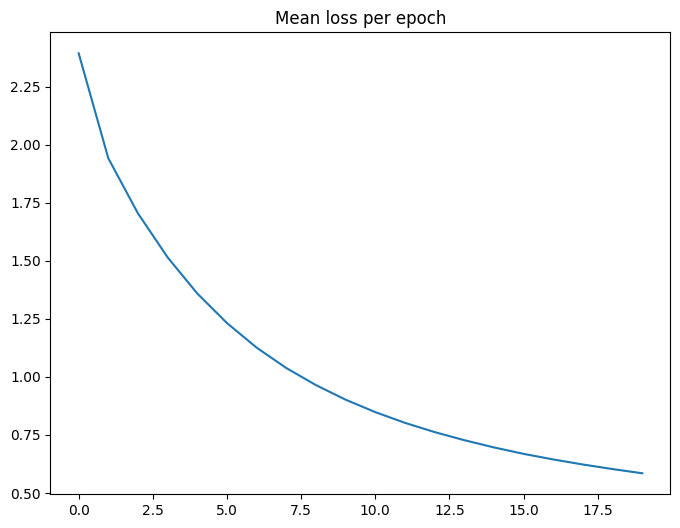

In [56]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

simple_3L_network = NerualNetworkBase(
  [Dense(28*28, 120), ReLU(), Dense(120, 10), Softmax()],
  cross_entropy_loss 
) 

simple_3L_network.train(
    X_train,
    y_train,
    batch_size=50,
    learning_rate=10e-5,
    epochs=20, print_epoch_loss=True)
simple_3L_network.print_total_time()
simple_3L_network.show_loss()

In [57]:
predictions = simple_3L_network.predict(X_test)
y_pred = [np.argmax(predictions[i]) for i in range(len(predictions))]
y_true = [np.argmax(y_test[i]) for i in range(len(y_test))]
accuracy_simple = accuracy_score(y_true, y_pred)
f1_simple = f1_score(y_true, y_pred, average='macro')

# LeNet (будет скоро), пока что LeNet / 4
### Архитектура
#### Input ► Conv 5x5 на 6 feature map ► MaxPooling 2x2 ► Reshape ► Dense-120 ► Softmax ► Output 
* Lr = 0.00001
* batch_size = 50
* epochs = 20


### Epoch: 1, time: 187.38s, mean loss: 1.55794696
### Epoch: 2, time: 187.41s, mean loss: 0.63318400
### Epoch: 3, time: 186.27s, mean loss: 0.47193581
### Epoch: 4, time: 189.83s, mean loss: 0.39030702
### Epoch: 5, time: 192.18s, mean loss: 0.34417013
### Epoch: 6, time: 191.21s, mean loss: 0.30437318
### Epoch: 7, time: 190.57s, mean loss: 0.27448074
### Epoch: 8, time: 191.27s, mean loss: 0.25351855
### Epoch: 9, time: 191.11s, mean loss: 0.23430370
### Epoch: 10, time: 193.84s, mean loss: 0.21565338
### Epoch: 11, time: 191.66s, mean loss: 0.19707624
### Epoch: 12, time: 192.12s, mean loss: 0.18544260
### Epoch: 13, time: 191.89s, mean loss: 0.17415343
### Epoch: 14, time: 192.38s, mean loss: 0.16343865
### Epoch: 15, time: 192.42s, mean loss: 0.15484882
### Epoch: 16, time: 192.57s, mean loss: 0.14716674
### Epoch: 17, time: 190.34s, mean loss: 0.13848394
### Epoch: 18, time: 190.25s, mean loss: 0.12956369
### Epoch: 19, time: 190.64s, mean loss: 0.12443805
### Epoch: 20, time: 

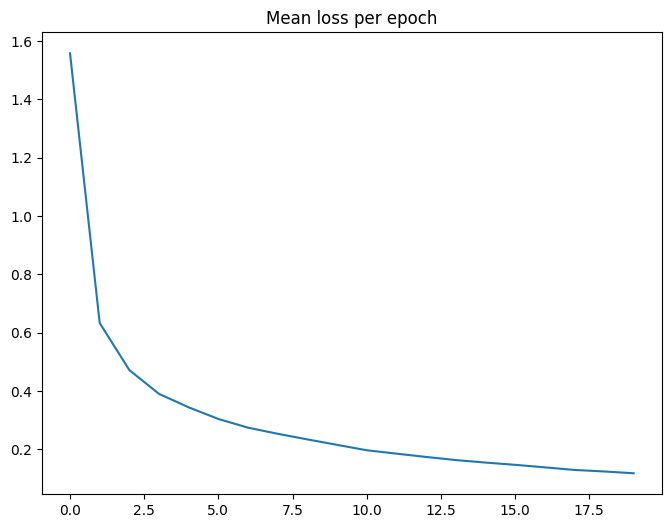

In [7]:
X_train = X_train.reshape(-1, 1,28,28)
X_test = X_test.reshape(-1, 1,28,28)

lenet5 = NerualNetworkBase(
    [
        Сonvolution(1, 6, 5),
        ReLU(),
        MaxPooling(2, 2),
        # Сonvolution(6, 16, 5),
        # ReLU(),
        # MaxPooling(2,2),
        Reshape((-1, 6*12*12)),
        Dense(6*12*12, 120),
        # ReLU(),
        # Dense(120,84),
        ReLU(),
        Dense(120, 10),
        Softmax()
    ],
    cross_entropy_loss
)

lenet5.train(X_train, y_train, batch_size=50, learning_rate=10e-5, epochs=20, print_epoch_loss=True)
lenet5.print_total_time()
lenet5.show_loss()

In [52]:
predictions = lenet5.predict(X_test)
y_pred = [np.argmax(predictions[i]) for i in range(len(predictions))]
y_true = [np.argmax(y_test[i]) for i in range(len(y_test))]
accuracy_cnn = accuracy_score(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')

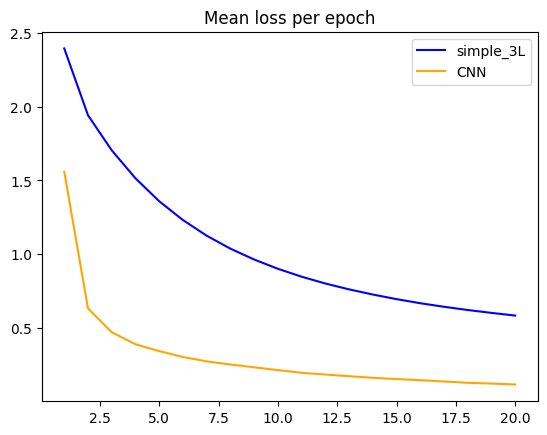

In [58]:
simple_loss = simple_3L_network.get_loss()
lenet5_loss = lenet5.get_loss()
x = range(1, len(simple_loss) + 1)

plt.plot(x, simple_loss, color='blue', label = 'simple_3L')
plt.plot(x, lenet5_loss, color='orange', label = 'CNN')
plt.title('Mean loss per epoch')
plt.legend()
plt.show()

# Сравнение accuracy и f1_score
### Обучение проводилось с одинковыми гиперпараметрами на датасете предобработанном MNIST: 300 * 10 для тренировки и 90 * 10 для валидации.

In [59]:
diff = pd.DataFrame({
    'Модель': ['Simple 3L network', 'CNN with 1 conv layer'],
    'Время обучения': ['0.55s','3815s'],
    'Accuracy': [round(accuracy_simple, 5), round(accuracy_cnn, 5)],
    'F1 macro': [round(f1_simple, 5), round(f1_cnn, 5)],
})
diff

,Модель,Время обучения,Accuracy,F1 macro
0,Simple 3L network,0.55s,0.83222,0.83095
1,CNN with 1 conv layer,3815s,0.91000,0.91033
